### Import Data

In [2]:
import torch
import numpy as np
from data.dataset_supervised import JumpDataset, get_dataloaders

DATA_PATH = "/home/atari_ws/data/learning_jump_feasibility"

train_dataset = JumpDataset(data_path=DATA_PATH, split="train", normalize=True)
test_dataset = JumpDataset(data_path=DATA_PATH, split="test", normalize=True)

def load_samples(dataset : JumpDataset, only_positive : bool = True):
    # Train data
    data = torch.cat(
        (
            dataset.input_states,
            dataset.current_contacts,
            dataset.achieved_contacts
        ), 1)
    
    if only_positive:
        positive_target = dataset.feasibilities == 1
        input = data[positive_target[:, 0]]
        target = dataset.feasibilities[positive_target].reshape(-1, 1)
    else:
        input = data
        target = dataset.feasibilities
        
    print("---", dataset.split)
    print("input shape:", input.shape)
    print("target shape:", target.shape)
    
    return input, target

In [3]:
# Train data
X_train, y_train = load_samples(train_dataset, only_positive=True)

# Test data
X_test, y_test = load_samples(test_dataset, only_positive=False)

--- train
input shape: torch.Size([119255, 51])
target shape: torch.Size([119255, 1])
--- test
input shape: torch.Size([9727, 51])
target shape: torch.Size([9727, 1])


In [116]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import FixedThresholdClassifier

from sklearn.metrics import roc_auc_score, roc_curve, ConfusionMatrixDisplay

X_train = X_train
y_train = y_train

estimators = {
    "GMM" : GaussianMixture(n_components=1, covariance_type='full', random_state=0, max_iter=1000, init_params="k-means++"),
    "OneClass-SVM" : OneClassSVM(nu=0.3, kernel="rbf", gamma=2.),
    "LOF": LocalOutlierFactor(novelty=True),
    "Isolation-Forest" : IsolationForest(n_estimators=200),
    "EllipticEnvelope" : EllipticEnvelope(contamination=0.1),
}

# Fit estimators and calculate ROC-AUC scores
roc_scores = {}

ID = list(range(-20, 0))

for name, estimator in estimators.items():
    estimator.fit(X_train[::10, ID])
    scores = estimator.score_samples(X_test[:, ID])
    
    roc_score = roc_auc_score(y_test, scores)
    roc_scores[name] = roc_score
    
    print(name, ":", roc_score)

# Find the best estimator
best_estimator = max(roc_scores, key=roc_scores.get)
best_roc_score = roc_scores[best_estimator]

print(f"Best Estimator: {best_estimator} with ROC-AUC Score: {best_roc_score}")


GMM : 0.8490643421050446
OneClass-SVM : 0.7767664562472119
LOF : 0.7194831250149868
Isolation-Forest : 0.8274079708684319
EllipticEnvelope : 0.8389043563688388
Best Estimator: GMM with ROC-AUC Score: 0.8490643421050446


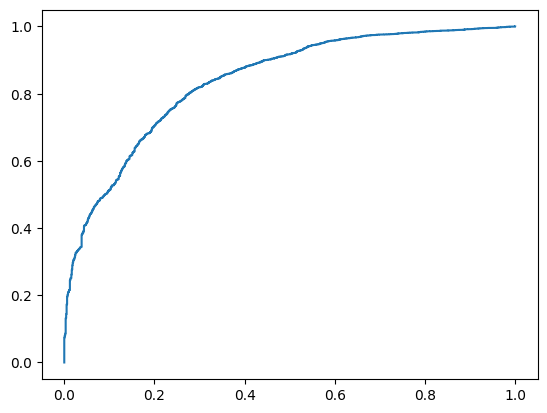

In [117]:
scores = estimator.score_samples(X_test[:, ID])

fpr, fnr, threshold = roc_curve(y_test, scores)

plt.plot(fpr, fnr)
plt.show()

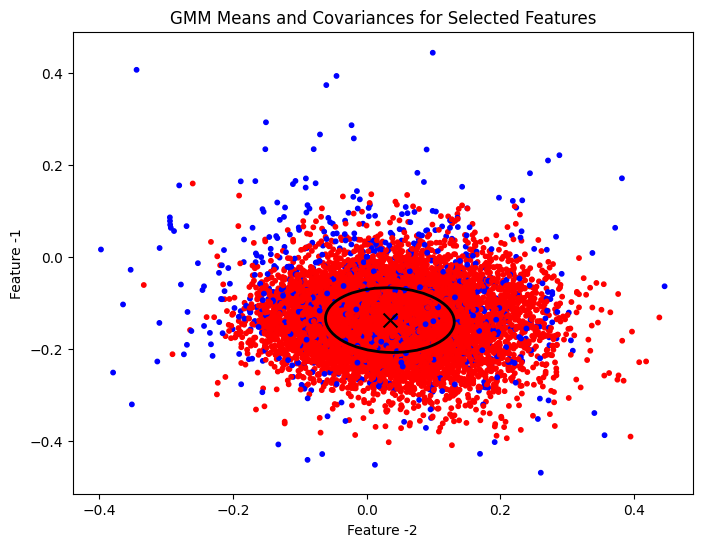

In [137]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture

# Select the features to plot (e.g., features 0 and 1)
feature_indices = [-2, -1]
selected_data = X_test[:, feature_indices]

gmm = estimators["GMM"]

# Extract means and covariances for the selected features
means = gmm.means_[:, -2:]
covariances = gmm.covariances_[:, -2:, -2:]

# Function to plot the Gaussian ellipses
def plot_gaussian_ellipses(means, covariances, ax):
    for mean, cov in zip(means, covariances):
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
        width, height = 2 * np.sqrt(eigenvalues)
        
        ell = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor='k', fc='None', lw=2)
        ax.add_patch(ell)
        ax.scatter(*mean, c='k', s=100, marker='x')

# Plot the data and the Gaussian ellipses
fig, ax = plt.subplots(figsize=(8, 6))
C = ["b", "r"]
colors = [C[int(label[0])] for label in y_test.tolist()]
ax.scatter(selected_data[:, 0], selected_data[:, 1], s=10, c=colors)
plot_gaussian_ellipses(means, covariances, ax)

ax.set_xlabel(f'Feature {feature_indices[0]}')
ax.set_ylabel(f'Feature {feature_indices[1]}')
ax.set_title('GMM Means and Covariances for Selected Features')
plt.show()

-8


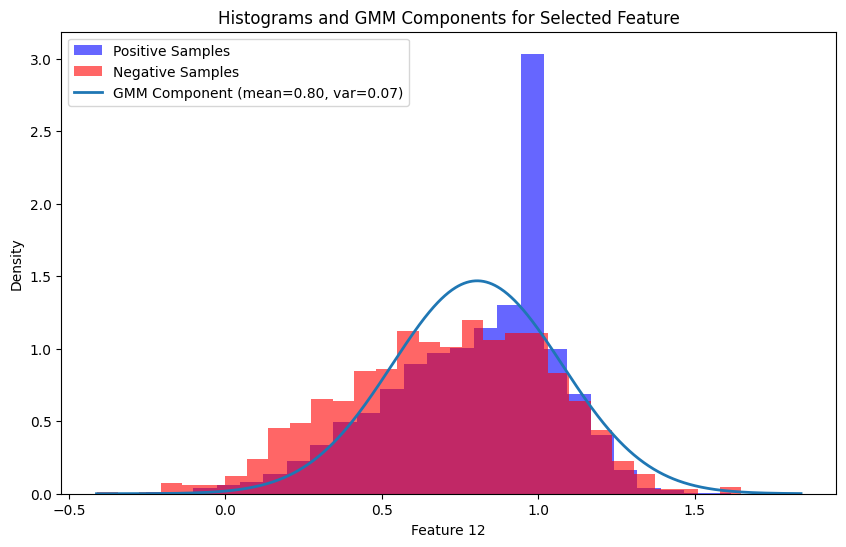

In [132]:

# Select the feature to plot (e.g., feature 0)
feature_index = 12
print(ID[feature_index])
positive_feature = X_test[y_test[:, 0] == 1, feature_index]
negative_feature = X_test[y_test[:, 0] == 0, feature_index]


gmm = estimators["GMM"]
gmm.fit(X_train)

# Extract means and variances for the selected feature
means = gmm.means_[:, feature_index]
covariances = gmm.covariances_[:, feature_index, feature_index]
variances = covariances  # For 1D case, variance is the covariance

# Plot histograms for positive and negative samples
plt.figure(figsize=(10, 6))
plt.hist(positive_feature, bins=30, alpha=0.6, label='Positive Samples', color='blue', density=True)
plt.hist(negative_feature, bins=30, alpha=0.6, label='Negative Samples', color='red', density=True)

# Plot GMM components
x = np.linspace(min(positive_feature.min(), negative_feature.min()), max(positive_feature.max(), negative_feature.max()), 1000)
for mean, var in zip(means, variances):
    plt.plot(x, 1/np.sqrt(2 * np.pi * var) * np.exp(-0.5 * (x - mean) ** 2 / var), lw=2, label=f'GMM Component (mean={mean:.2f}, var={var:.2f})')

plt.xlabel(f'Feature {feature_index}')
plt.ylabel('Density')
plt.title('Histograms and GMM Components for Selected Feature')
plt.legend()
plt.show()

In [16]:
import torch
import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


class TrainDataset():
    def __init__(self, train_dataset) -> None:
        self.train_dataset = train_dataset
    
    def __len__(self):
        return len(self.train_dataset)
    
    def __getitem__(self, idx):
        return {"input":self.train_dataset[idx], "target":1}
    
class TestDataset():
    def __init__(self, test_dataset, test_label) -> None:
        self.test_dataset = test_dataset
        self.test_label = test_label
    
    def __len__(self):
        return len(self.test_dataset)
    
    def __getitem__(self, idx):
        return {"input":self.test_dataset[idx], "target":self.test_label[idx]}

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim//2),
            nn.ReLU(),
            nn.Linear(input_dim//2, encoding_dim),
            nn.ReLU(),
            nn.Linear(encoding_dim, encoding_dim),
            nn.BatchNorm1d(encoding_dim),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, encoding_dim),
            nn.BatchNorm1d(encoding_dim),
            nn.ReLU(),
            nn.Linear(encoding_dim, input_dim//2),
            nn.ReLU(),
            nn.Linear(input_dim//2, input_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

num_epochs = 200
batch_size = 64


train_d = TrainDataset(X_train)
test_d = TestDataset(X_test, y_test)

train_loader = DataLoader(train_d, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_d, batch_size=batch_size)

batch = next(iter(test_loader))
device = "cuda" if torch.cuda.is_available() else "cpu"

input_dim = batch["input"].shape[-1]
encoding_dim = 20
autoencoder = Autoencoder(input_dim, encoding_dim).to(device)

# Train the autoencoder
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)

progress_bar = tqdm.trange(num_epochs)
for epoch in progress_bar:
    for batch in train_loader:
        inputs = batch["input"].to(device)
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    progress_bar.set_postfix({"Loss": loss.item()})


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Classification Accuracy: 0.2192


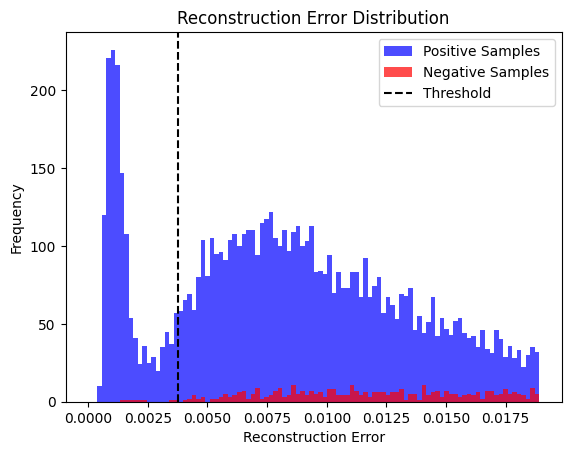

In [12]:
autoencoder.to("cpu")
# Calculate reconstruction errors
with torch.no_grad():
    reconstructed = autoencoder(X_test)
reconstruction_errors = torch.mean((X_test - reconstructed) ** 2, dim=1).numpy()

# Determine the threshold based on the training data
threshold = np.percentile(reconstruction_errors, 15)

# Classify test samples based on the threshold
test_predictions = reconstruction_errors > threshold
y_pred = np.ones_like(test_predictions)
y_pred[test_predictions] = 0

# Calculate accuracy
accuracy = np.mean(y_pred == y_test.numpy())

print(f'Classification Accuracy: {accuracy:.4f}')

# Plot the reconstruction error distribution
plt.hist(reconstruction_errors[(y_test == 1)[:, 0]], bins=100, alpha=0.7, range=[0, 5*threshold], label='Positive Samples', color='blue')
plt.hist(reconstruction_errors[(y_test == 0)[:, 0]], bins=100, alpha=0.7, range=[0, 5*threshold], label='Negative Samples', color='red')
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve, ConfusionMatrixDisplay

roc_auc_score(y_test, 1. / reconstruction_errors)

0.7865580358128547

In [18]:
import torch
import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt


class TrainDataset():
    def __init__(self, train_dataset) -> None:
        self.train_dataset = train_dataset
    
    def __len__(self):
        return len(self.train_dataset)
    
    def __getitem__(self, idx):
        return {"input":self.train_dataset[idx], "target":1}
    
class TestDataset():
    def __init__(self, test_dataset, test_label) -> None:
        self.test_dataset = test_dataset
        self.test_label = test_label
    
    def __len__(self):
        return len(self.test_dataset)
    
    def __getitem__(self, idx):
        return {"input":self.test_dataset[idx], "target":self.test_label[idx]}

num_epochs = 200
batch_size = 64


train_d = TrainDataset(X_train)
test_d = TestDataset(X_test, y_test)

train_loader = DataLoader(train_d, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_d, batch_size=batch_size)

batch = next(iter(test_loader))
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define the neural network for feature extraction
class DeepSVDDNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DeepSVDDNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# Initialize the network and center
input_dim = X_train.shape[1]
hidden_dim = 32
net = DeepSVDDNet(input_dim, hidden_dim).to(device)


num_epochs = 50
batch_size = 64


# Calculate the center of the hypersphere
def calculate_center(dataloader):
    net.eval()
    with torch.no_grad():
        total = 0
        center = torch.zeros(input_dim)
        for data in dataloader:
            inputs = data["input"].to(device)
            outputs = net(inputs)
            center += outputs.sum(dim=0)
            total += outputs.size(0)
        center /= total
    net.train()
    return center

# Initialize the center c
c = calculate_center(train_loader)

# Define the objective function and optimizer
def deep_svdd_loss(output, target, c, nu):
    distances = torch.sum((output - c) ** 2, dim=1)
    return torch.mean(distances) + nu * torch.mean(torch.max(torch.zeros_like(distances), distances))

optimizer = optim.Adam(net.parameters(), lr=0.01)
nu = 0.1
num_epochs = 50

# Train the network
for epoch in range(num_epochs):
    for data in train_loader:
        inputs = data["input"].to(device)
        outputs = net(inputs)
        loss = deep_svdd_loss(outputs, inputs, c, nu)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Combine positive and negative data for testing
test_data = X_test
test_labels = y_test

# Calculate distances to the center
with torch.no_grad():
    outputs = net(test_data)
distances = torch.sum((outputs - c) ** 2, dim=1).numpy()

# Determine the threshold based on the training data
threshold = np.percentile(distances, 50)

# Classify test samples based on the threshold
test_predictions = distances > threshold
y_pred = np.ones_like(test_predictions)
y_pred[test_predictions] = 0

# Calculate accuracy
accuracy = np.mean(y_pred == y_test.numpy())

print(f'Classification Accuracy: {accuracy:.4f}')

# Plot the reconstruction error distribution
plt.hist(reconstruction_errors[(y_test == 1)[:, 0]], bins=100, alpha=0.7, range=[0, 5*threshold], label='Positive Samples', color='blue')
plt.hist(reconstruction_errors[(y_test == 0)[:, 0]], bins=100, alpha=0.7, range=[0, 5*threshold], label='Negative Samples', color='red')
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.legend()

Epoch [1/50], Loss: 0.0000
Epoch [2/50], Loss: 0.0000
Epoch [3/50], Loss: 0.0000
Epoch [4/50], Loss: 0.0000
Epoch [5/50], Loss: 0.0000
Epoch [6/50], Loss: 0.0000
Epoch [7/50], Loss: 0.0000
Epoch [8/50], Loss: 0.0000
Epoch [9/50], Loss: 0.0000
Epoch [10/50], Loss: 0.0000
Epoch [11/50], Loss: 0.0000
Epoch [12/50], Loss: 0.0000
Epoch [13/50], Loss: 0.0000
Epoch [14/50], Loss: 0.0000
Epoch [15/50], Loss: 0.0000
Epoch [16/50], Loss: 0.0000
Epoch [17/50], Loss: 0.0000
Epoch [18/50], Loss: 0.0000
Epoch [19/50], Loss: 0.0000
Epoch [20/50], Loss: 0.0000
Epoch [21/50], Loss: 0.0000
Epoch [22/50], Loss: 0.0000
Epoch [23/50], Loss: 0.0000
Epoch [24/50], Loss: 0.0000
Epoch [25/50], Loss: 0.0000
Epoch [26/50], Loss: 0.0000
Epoch [27/50], Loss: 0.0000
Epoch [28/50], Loss: 0.0000
Epoch [29/50], Loss: 0.0000
Epoch [30/50], Loss: 0.0000
Epoch [31/50], Loss: 0.0000
Epoch [32/50], Loss: 0.0000
Epoch [33/50], Loss: 0.0000
Epoch [34/50], Loss: 0.0000
Epoch [35/50], Loss: 0.0000
Epoch [36/50], Loss: 0.0000
E